# LinkedIn Job Postings

## ADS 508 Impacting the Business with a Distributed Data Science Pipeline

In [1]:
# Import packages
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import boto3
import sagemaker
from pyathena import connect
import awswrangler as wr
from collections import Counter
from wordcloud import WordCloud

import warnings
warnings.filterwarnings('ignore')

## Data Ingestion

### CSV to S3

In [2]:
# Setup boto3 session parameters
session = sagemaker.Session()
bucket = session.default_bucket()
role = sagemaker.get_execution_role()
region = boto3.Session().region_name
account_id = boto3.client("sts").get_caller_identity().get("Account")

# Establish connection
sm = boto3.Session().client(service_name="sagemaker", region_name=region)

In [3]:
# Set S3 Source Location (Public bucket)
s3_public_path = "s3://linkedin-postings"

In [4]:
%store s3_public_path

Stored 's3_public_path' (str)


In [5]:
# Set S3 Destination Location (Private bucket)
s3_private_path = "s3://{}/linkedin_data".format(bucket)
print(s3_private_path)

s3://sagemaker-us-east-1-937572952481/linkedin_data


In [6]:
%store s3_private_path

Stored 's3_private_path' (str)


In [7]:
# Copy data from Public S3 bucket to Private S3 bucket
!aws s3 cp --recursive $s3_public_path/ $s3_private_path/ --exclude "*" --include "postings/postings.csv"
!aws s3 cp --recursive $s3_public_path/ $s3_private_path/ --exclude "*" --include "salaries/salaries.csv"
!aws s3 cp --recursive $s3_public_path/ $s3_private_path/ --exclude "*" --include "job_skills/job_skills.csv"

copy: s3://linkedin-postings/postings/postings.csv to s3://sagemaker-us-east-1-937572952481/linkedin_data/postings/postings.csv
copy: s3://linkedin-postings/salaries/salaries.csv to s3://sagemaker-us-east-1-937572952481/linkedin_data/salaries/salaries.csv
copy: s3://linkedin-postings/job_skills/job_skills.csv to s3://sagemaker-us-east-1-937572952481/linkedin_data/job_skills/job_skills.csv


In [8]:
# Check files are copied successfully to private bucket
!aws s3 ls $s3_private_path/

                           PRE job_skills/
                           PRE postings/
                           PRE salaries/


### Create Athena Database 

In [9]:
ingest_create_athena_db_passed = False

In [10]:
ingest_create_athena_table_passed = False

In [11]:
database_name = "linkedin_data"

In [12]:
# Set S3 staging directory - a temporary directory for Athena queries
s3_staging_dir = "s3://{}/athena/staging".format(bucket)

In [13]:
# Connect to staging directory
conn = connect(region_name=region, s3_staging_dir=s3_staging_dir)

In [14]:
# Create Database
statement = "CREATE DATABASE IF NOT EXISTS {}".format(database_name)

pd.read_sql(statement, conn)

""


### Verify database has been created

In [15]:
statement = "SHOW DATABASES"

df_show = pd.read_sql(statement, conn)
df_show.head(5)

,database_name
0,default
1,dsoaws
2,linkedin_data


In [16]:
if database_name in df_show.values:
    ingest_create_athena_db_passed = True

### Create Athena Tables from CSV Files

In [17]:
table_name = 'postings'
postings_path = "s3://{}/linkedin_data/postings/".format(bucket)

drop_statement = """DROP TABLE IF EXISTS {}.{};""".format(database_name, table_name)

print(drop_statement)
pd.read_sql(drop_statement, conn)
print("Attempted to Drop {} table".format(table_name))

DROP TABLE IF EXISTS linkedin_data.postings;
Attempted to Drop postings table


In [18]:
# SQL statement to execute the postings table
statement = """
    CREATE EXTERNAL TABLE IF NOT EXISTS {}.{}(
        job_id string,
        company_name string,
        title string,
        description string,
        max_salary float,
        pay_period string,
        location string,
        company_id float,
        views float,
        med_salary float,
        min_salary float,
        formatted_work_type string,
        applies float,
        original_listed_time float,
        remote_allowed float,
        job_posting_url string,
        application_url string,
        application_type string,
        expiry float,
        closed_time float,
        formatted_experience_level string,
        skills_desc string,
        listed_time string,
        posting_domain string,
        sponsored int,
        work_type string,
        currency string,
        compensation_type string,
        normalized_salary float,
        zip_code int,
        fips int
    ) 
    ROW FORMAT DELIMITED FIELDS TERMINATED BY ','
    LOCATION '{}' 
    TBLPROPERTIES ('skip.header.line.count'='1')
    """.format(database_name, table_name, postings_path)

# Execute statement
pd.read_sql(statement, conn)
print("Created postings table")

Created postings table


In [19]:
table_name_2 = "salaries"
salaries_path = "s3://{}/linkedin_data/salaries/".format(bucket)

drop_statement2 = """DROP TABLE IF EXISTS {}.{};""".format(database_name, table_name_2)

print(drop_statement2)
pd.read_sql(drop_statement2, conn)
print("Attempted to Drop {} table".format(table_name_2))

DROP TABLE IF EXISTS linkedin_data.salaries;
Attempted to Drop salaries table


In [20]:
# SQL statement to execute the postings table
statement = """
    CREATE EXTERNAL TABLE IF NOT EXISTS {}.{}(
        salary_id int,
        job_id string,
        max_salary float,
        med_salary float,
        min_salary float,
        pay_period string,
        currency string,
        compensation_type string
    ) 
    ROW FORMAT DELIMITED FIELDS TERMINATED BY ','
    LOCATION '{}' 
    TBLPROPERTIES ('skip.header.line.count'='1')
    """.format(database_name, table_name_2, salaries_path)

# Execute statement
pd.read_sql(statement, conn)
print("Created salaries table")

Created salaries table


In [21]:
table_name_3 = "job_skills"
job_skills_path = "s3://{}/linkedin_data/job_skills/".format(bucket)

drop_statement3 = """DROP TABLE IF EXISTS {}.{};""".format(database_name, table_name_3)

print(drop_statement3)
pd.read_sql(drop_statement3, conn)
print("Attempted to Drop {} table".format(table_name_3))

DROP TABLE IF EXISTS linkedin_data.job_skills;
Attempted to Drop job_skills table


In [22]:
# SQL statement to execute the postings table
statement = """
    CREATE EXTERNAL TABLE IF NOT EXISTS {}.{}(
        job_id string,
        skill_abr string
    ) 
    ROW FORMAT DELIMITED FIELDS TERMINATED BY ','
    LOCATION '{}' 
    TBLPROPERTIES ('skip.header.line.count'='1')
    """.format(database_name, table_name_3, job_skills_path)

# Execute statement
pd.read_sql(statement, conn)
print("Created job_skills table")

Created job_skills table


### Verify tables have been created successfully

In [23]:
statement = "SHOW TABLES in {}".format(database_name)

df_show = pd.read_sql(statement, conn)
df_show.head(5)

,tab_name
0,job_skills
1,postings
2,salaries


In [24]:
if table_name in df_show.values:
    ingest_create_athena_table_passed = True

In [25]:
# View postings table to check the data looks correct
statement = """SELECT * FROM {}.{} LIMIT 5""".format(database_name, table_name)

pd.read_sql(statement, conn)

,job_id,company_name,title,description,max_salary,pay_period,location,company_id,views,med_salary,...,skills_desc,listed_time,posting_domain,sponsored,work_type,currency,compensation_type,normalized_salary,zip_code,fips
0,,None,None,None,None,None,None,None,None,None,...,None,None,None,None,None,None,None,None,None,None
1,Salary Range: $157,335 - $401,180,annually Actual salary offered may vary depen...,None,education,******al pay alignment,None,None,None,...,None,None,None,None,None,None,None,None,None,None
2,,None,None,None,None,None,None,None,None,None,...,None,None,None,None,None,None,None,None,None,None
3,ENGIE complies with all federal,state,and local minimum w****** laws.,None,None,None,None,None,None,None,...,None,None,None,None,None,None,None,None,None,None
4,,None,None,None,None,None,None,None,None,None,...,None,None,None,None,None,None,None,None,None,None


In [27]:
# View salaries table to check the data looks correct
statement = """SELECT * FROM {}.{} LIMIT 5""".format(database_name, table_name_2)

pd.read_sql(statement, conn)

,salary_id,job_id,max_salary,med_salary,min_salary,pay_period,currency,compensation_type
0,1,3884428798,NaN,20.0,NaN,HOURLY,USD,BASE_SALARY
1,2,3887470552,25.0,NaN,23.0,HOURLY,USD,BASE_SALARY
2,3,3884431523,120000.0,NaN,100000.0,YEARLY,USD,BASE_SALARY
3,4,3884911725,200000.0,NaN,10000.0,YEARLY,USD,BASE_SALARY
4,5,3887473220,35.0,NaN,33.0,HOURLY,USD,BASE_SALARY


In [28]:
# View job skills table to check the data looks correct
statement = """SELECT * FROM {}.{} LIMIT 5""".format(database_name, table_name_3)

pd.read_sql(statement, conn)

,job_id,skill_abr
0,3884428798,MRKT
1,3884428798,PR
2,3884428798,WRT
3,3887473071,SALE
4,3887465684,FIN


## Data Exploration

In [ ]:
statement = """SELECT * FROM {}.{}""".format(database_name, table_name)
postings_df = pd.read_sql(statement, conn)

In [ ]:
statement = """SELECT * FROM {}.{}""".format(database_name, table_name_2)
salaries_df = pd.read_sql(statement, conn)

In [ ]:
statement = """SELECT * FROM {}.{}""".format(database_name, table_name_3)
job_skills_df = pd.read_sql(statement, conn)

### postings EDA

In [43]:
# Basic stats
print(postings_df.describe())
print(postings_df.info())

       max_salary    company_id     views  med_salary    min_salary  \
count         1.0  7.000000e+00  2.000000         1.0  3.000000e+00   
mean   14820947.0  3.568337e+05  4.000000     90000.0  5.709537e+11   
std           NaN  5.392871e+05  1.414214         NaN  9.889209e+11   
min    14820947.0  1.000000e+00  3.000000     90000.0  5.000000e+01   
25%    14820947.0  2.500000e+00  3.500000     90000.0  5.970500e+03   
50%    14820947.0  2.400000e+01  4.000000     90000.0  1.189100e+04   
75%    14820947.0  6.099130e+05  4.500000     90000.0  8.564306e+11   
max    14820947.0  1.277980e+06  5.000000     90000.0  1.712861e+12   

            applies  original_listed_time  remote_allowed        expiry  \
count  5.000000e+00          4.000000e+00        2.000000  2.000000e+00   
mean   1.370289e+12          8.564138e+11   100000.500000  1.715453e+12   
std    7.660146e+11          9.889014e+11   141420.649131  2.757716e+05   
min    1.000000e+00          1.000000e+00        1.000000  1

In [44]:
# Data types
postings_data_types = postings_df.dtypes
print(postings_data_types)

job_id                         object
company_name                   object
title                          object
description                    object
max_salary                    float64
pay_period                     object
location                       object
company_id                    float64
views                         float64
med_salary                    float64
min_salary                    float64
formatted_work_type            object
applies                       float64
original_listed_time          float64
remote_allowed                float64
job_posting_url                object
application_url                object
application_type               object
expiry                        float64
closed_time                   float64
formatted_experience_level     object
skills_desc                    object
listed_time                    object
posting_domain                 object
sponsored                     float64
work_type                      object
currency    

In [45]:
# Missing values
postings_df.isnull().sum()

job_id                         0
company_name                  31
title                         39
description                   45
max_salary                    99
pay_period                    64
location                      66
company_id                    93
views                         98
med_salary                    99
min_salary                    97
formatted_work_type           80
applies                       95
original_listed_time          96
remote_allowed                98
job_posting_url               83
application_url               84
application_type              84
expiry                        98
closed_time                   99
formatted_experience_level    84
skills_desc                   84
listed_time                   85
posting_domain                85
sponsored                     98
work_type                     85
currency                      85
compensation_type             85
normalized_salary             94
zip_code                      96
fips      

In [46]:
# Duplicates
postings_df.duplicated().sum()

13

In [47]:
# Summary statistics
print(f"Unique Job Titles: {postings_df['title'].nunique()}")
print(f"Unique Companies: {postings_df['company_name'].nunique()}")

Unique Job Titles: 55
Unique Companies: 66


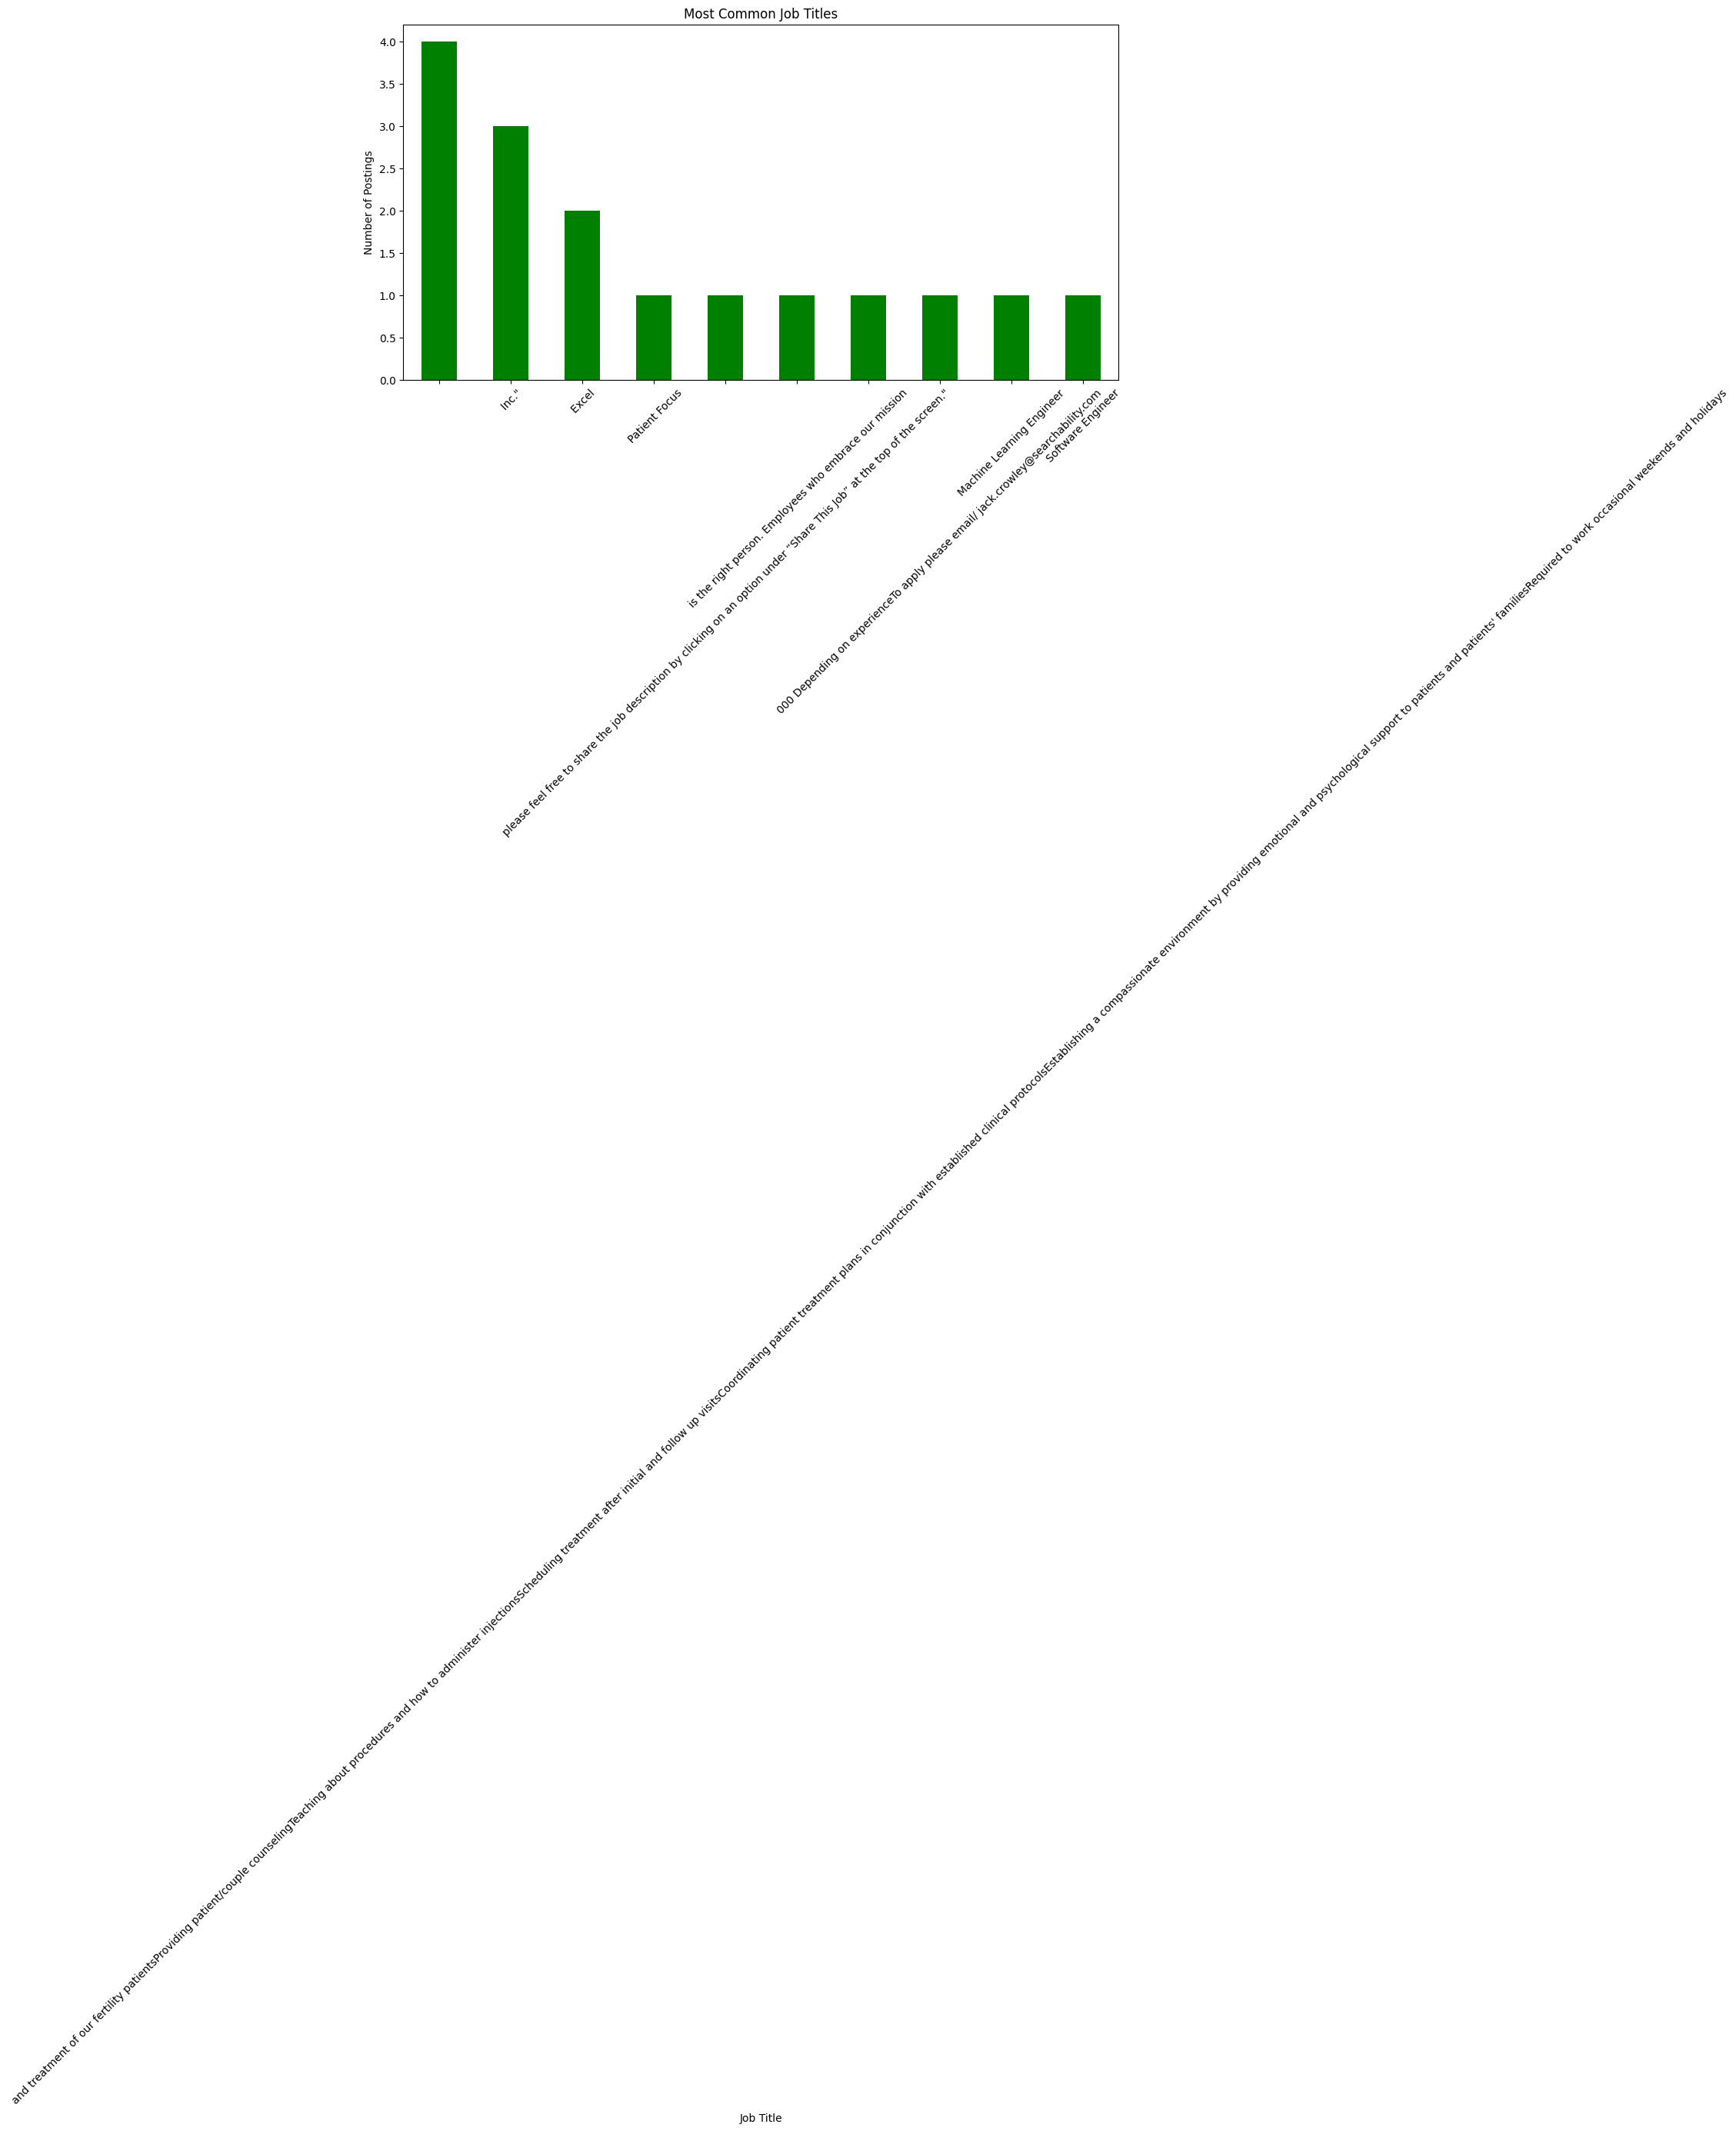

In [48]:
# Visualize most common job titles
plt.figure(figsize=(12,6))
postings_df['title'].value_counts().head(10).plot(kind='bar', color='green')
plt.xlabel("Job Title")
plt.ylabel("Number of Postings")
plt.title("Most Common Job Titles")
plt.xticks(rotation=45)
plt.show()

In [49]:
# Posting trends
postings_df['listed_time'] = postings_df.to_datetime(postings_df['listed_time'], unit='s')  # Convert Unix timestamp to datetime
postings_df.set_index('listed_time', inplace=True)

# Resample by month to see posting trends
postings_df.resample('M').size().plot(figsize=(12, 5), title="Job Posting Trends Over Time")
plt.ylabel("Number of Postings")
plt.show()

AttributeError: 'DataFrame' object has no attribute 'to_datetime'

### salaries EDA

In [50]:
# Basic stats
print(salaries_df.describe())
print(salaries_df.info())

          salary_id    max_salary     med_salary    min_salary
count  40785.000000  3.394700e+04    6838.000000  3.394700e+04
mean   20393.000000  9.620987e+04   21370.298198  6.508541e+04
std    11773.759701  6.587373e+05   51338.564169  4.650612e+05
min        1.000000  1.000000e+00       0.000000  1.000000e+00
25%    10197.000000  5.000000e+01      18.500000  3.900000e+01
50%    20393.000000  8.500000e+04      25.000000  6.230000e+04
75%    30589.000000  1.425000e+05    2207.000000  1.000000e+05
max    40785.000000  1.200000e+08  750000.000000  8.500000e+07
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 40785 entries, 0 to 40784
Data columns (total 8 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   salary_id          40785 non-null  int64  
 1   job_id             40785 non-null  object 
 2   max_salary         33947 non-null  float64
 3   med_salary         6838 non-null   float64
 4   min_salary         33947 non-nul

In [51]:
# Data types
salaries_data_types = salaries_df.dtypes
print(salaries_data_types)

salary_id              int64
job_id                object
max_salary           float64
med_salary           float64
min_salary           float64
pay_period            object
currency              object
compensation_type     object
dtype: object


In [52]:
# Missing values
salaries_df.isnull().sum()

salary_id                0
job_id                   0
max_salary            6838
med_salary           33947
min_salary            6838
pay_period               0
currency                 0
compensation_type        0
dtype: int64

In [53]:
# Duplicates
salaries_df.duplicated().sum()

0

In [54]:
# Salary distributions
print("Max Salary: ", salaries_df['max_salary'].describe())
print("Min Salary: ", salaries_df['min_salary'].describe())
print("Median Salary: ", salaries_df['med_salary'].describe())
# print(df[['min_salary', 'med_salary', 'max_salary', 'normalized_salary']].describe())

Max Salary:  count    3.394700e+04
mean     9.620987e+04
std      6.587373e+05
min      1.000000e+00
25%      5.000000e+01
50%      8.500000e+04
75%      1.425000e+05
max      1.200000e+08
Name: max_salary, dtype: float64
Min Salary:  count    3.394700e+04
mean     6.508541e+04
std      4.650612e+05
min      1.000000e+00
25%      3.900000e+01
50%      6.230000e+04
75%      1.000000e+05
max      8.500000e+07
Name: min_salary, dtype: float64
Median Salary:  count      6838.000000
mean      21370.298198
std       51338.564169
min           0.000000
25%          18.500000
50%          25.000000
75%        2207.000000
max      750000.000000
Name: med_salary, dtype: float64


AttributeError: Rectangle.set() got an unexpected keyword argument 'bins'

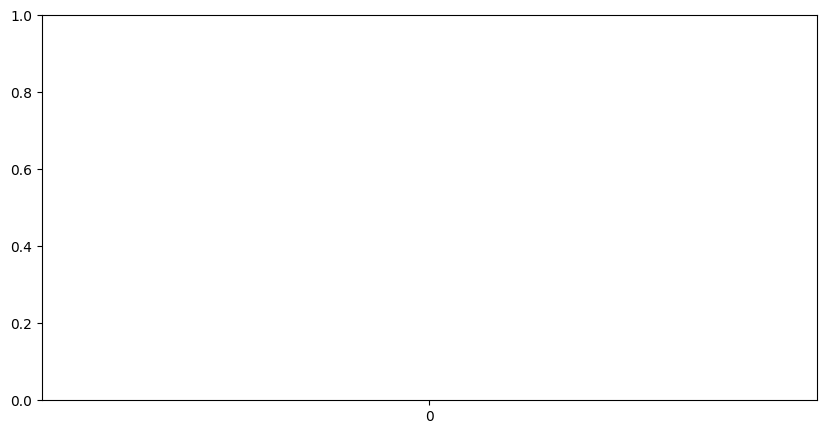

In [55]:
# Visualize salary distribution
plt.figure(figsize=(10,5))
sns.barplot(postings_df['normalized_salary'], bins=30, kde=True, color="blue")
plt.xlabel("Salary")
plt.ylabel("Frequency")
plt.title("Salary Distribution")
plt.show()

### job_skills EDA

In [56]:
# Basic stats
print(job_skills_df.describe())
print(job_skills_df.info())

            job_id skill_abr
count       213768    213768
unique      126807        35
top     3888474981        IT
freq             3     26137
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 213768 entries, 0 to 213767
Data columns (total 2 columns):
 #   Column     Non-Null Count   Dtype 
---  ------     --------------   ----- 
 0   job_id     213768 non-null  object
 1   skill_abr  213768 non-null  object
dtypes: object(2)
memory usage: 3.3+ MB
None


In [57]:
# Data types
job_skills_data_types = job_skills_df.dtypes
print(job_skills_data_types)

job_id       object
skill_abr    object
dtype: object


In [58]:
# Missing values
job_skills_df.isnull().sum()

job_id       0
skill_abr    0
dtype: int64

In [59]:
# Duplicates
job_skills_df.duplicated().sum()

0

In [60]:
# Summary statistics
print(f"Unique Job Skills: {job_skills_df['skill_abr'].nunique()}")

Unique Job Skills: 35


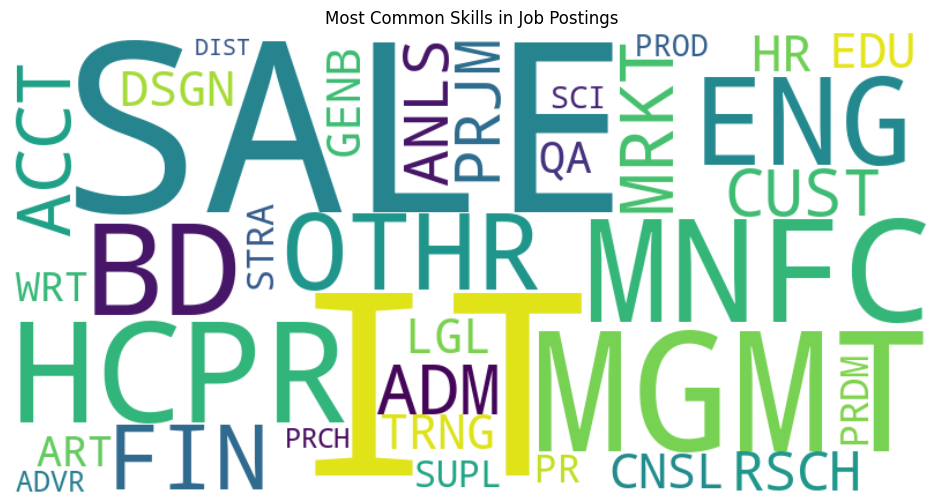

In [61]:
# Concatenate all skills descriptions
all_skills = " ".join(str(skill) for skill in job_skills_df['skill_abr'].dropna())

# Count word frequencies
word_counts = Counter(all_skills.split())

# Generate WordCloud
wordcloud = WordCloud(width=800, height=400, background_color="white").generate_from_frequencies(word_counts)

# Visualize most common job skills in job descriptions
plt.figure(figsize=(12,6))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.title("Most Common Skills in Job Postings")
plt.show()

### Bias Analysis

In [62]:
# Detecting Skewed Data in Job Roles shown above
# Detecting salary bias shown above

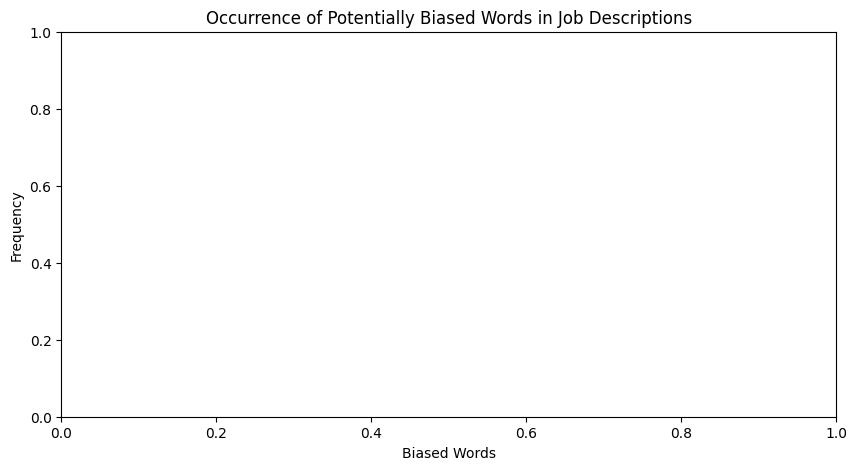

In [63]:
# Detecting Biased Language in Job Descriptions (might favor aggressive hiring cultures)

# List of biased words to check
biased_words = ["dominant", "aggressive", "competitive", "strong leader"]

# Count biased words in descriptions
word_counts = Counter(" ".join(str(desc) for desc in postings_df['description'].dropna()).lower().split())

# Filter for biased words
biased_word_freq = {word: word_counts[word] for word in biased_words if word in word_counts}

# Visualize word frequency
plt.figure(figsize=(10,5))
sns.barplot(x=list(biased_word_freq.keys()), y=list(biased_word_freq.values()), palette="Reds_r")
plt.xlabel("Biased Words")
plt.ylabel("Frequency")
plt.title("Occurrence of Potentially Biased Words in Job Descriptions")
plt.show()